<a href="https://colab.research.google.com/github/reshalfahsi/medical-image-similarity-search/blob/master/Medical_Image_Similarity_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Medical Image Similarity Search Using a Siamese Network With a Contrastive Loss**

## **Important Libraries**

### **Install**

In [1]:
!pip install -q --no-cache-dir lightning torchmetrics medmnist
!pip install -q --no-cache-dir faiss-cpu psycopg2-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 195.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 164.8 MB/s eta 0:00:00


In [2]:
!sudo apt update
!sudo apt install dirmngr ca-certificates software-properties-common gnupg gnupg2 \
 apt-transport-https curl -y
!curl -fSsL https://www.postgresql.org/media/keys/ACCC4CF8.asc | gpg --dearmor | \
 sudo tee /usr/share/keyrings/postgresql.gpg > /dev/null
!echo 'deb [arch=amd64,arm64,ppc64el signed-by=/usr/share/keyrings/postgresql.gpg] http://apt.postgresql.org/pub/repos/apt/ jammy-pgdg main' | \
 sudo tee /etc/apt/sources.list.d/pgdg.list
!sudo apt update
!sudo apt install postgresql-client-15 postgresql-15 -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [662 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,056 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,321 kB]
Hit:10 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,624 kB]
Hit:13 https:

In [3]:
!sudo service postgresql start

 * Starting PostgreSQL 15 database server
   ...done.


In [4]:
# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "CREATE ROLE root WITH SUPERUSER;"
!sudo -u postgres psql -U postgres -c "ALTER ROLE root WITH LOGIN;"
!sudo -u postgres psql -c "ALTER USER postgres PASSWORD 'postgres'"

CREATE ROLE
ALTER ROLE
ALTER ROLE


In [5]:
!sudo -u postgres createdb medicaldb

### **Import**

In [6]:
try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from torchmetrics.classification import BinaryAccuracy

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, Resize
from torchvision.datasets.utils import download_url

import faiss
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

from medmnist.info import INFO, HOMEPAGE, DEFAULT_ROOT

from PIL import Image

import os
import cv2
import math
import copy
import time
import random
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

### **Dataset**

In [7]:
DATASET = [
    "breastmnist",    # -> #00
    "dermamnist",     # -> #01
    "pneumoniamnist", # -> #02
    "retinamnist",    # -> #03
]

IMAGE_SIZE = 128

### **Hyperparameters**

In [8]:
EMBEDDING_DIM = 16
EPOCH         = int(np.array([x for x in np.geomspace(1, 8, num=4)]).sum())
BATCH_SIZE    = 64

In [9]:
EARLY_STOPPING_PATIENCE = 1./2
REDUCE_LR_FACTOR        = 1./4
REDUCE_LR_PATIENCE      = 1./16
LEARNING_RATE           = 1./512
WEIGHT_DECAY            = 1./1024

In [10]:
TOPK   = 4
BITS   = 2 * TOPK
NPROBE = 2 + BITS
NLIST  = EMBEDDING_DIM // 8

In [11]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 1607664275


### **PostgreSQL**

In [12]:
%load_ext sql
%config SqlMagic.feedback=False
%config SqlMagic.autopandas=True
%sql postgresql+psycopg2://@/medicaldb

In [13]:
%%sql

DROP TABLE IF EXISTS embeddings_table;

 * postgresql+psycopg2://@/medicaldb


""


In [14]:
%%sql

CREATE TABLE embeddings_table (
    id SERIAL PRIMARY KEY,
    embedding FLOAT[] NOT NULL
);

 * postgresql+psycopg2://@/medicaldb


""


## **Dataset**

### **Utils**

In [15]:
TRANSFORM = Compose(
    [
        Resize(IMAGE_SIZE),
        ToTensor(),
        Lambda(lambda x: (x * 2) - 1),
    ]
)

### **Biomedical Dataset**

In [16]:
class BiomedicalDataset(data.Dataset):
    flags = DATASET
    root = DEFAULT_ROOT
    transform = TRANSFORM
    split = None

    def __init__(self):

        for flag in self.flags:
            if not os.path.exists(f"/{self.root}/.medmnist/{flag}.npz"):
                self.download(flag)

    def __call__(self, split, inference_index=None):
        assert split is not None and split in [
            "train",
            "val",
            "test",
            "inference",
            "store_embedding",
        ], "Please define the dataset split: 'train', 'val', 'test', 'inference' or 'store_embedding'"

        self.split = split
        self.images = list()
        self.labels = list()

        if self.split == "train":
            for idx, flag in enumerate(self.flags):
                npz_file = np.load(os.path.join(self.root, "{}.npz".format(flag)))
                if npz_file["train_images"].shape[-1] != 3:
                    train_images = np.repeat(
                        np.reshape(
                            npz_file["train_images"],
                            (
                                npz_file["train_images"].shape[0],
                                npz_file["train_images"].shape[1],
                                npz_file["train_images"].shape[2],
                                1,
                            ),
                        ),
                        3,
                        axis=-1,
                    )
                else:
                    train_images = npz_file["train_images"]
                self.images += train_images.tolist()
                labels_ = np.zeros(npz_file["train_images"].shape[0])
                labels_.fill(idx)
                labels_ = labels_.astype(np.int)
                self.labels += labels_.tolist()

                del npz_file
        elif self.split == "val":
            for idx, flag in enumerate(self.flags):
                npz_file = np.load(os.path.join(self.root, "{}.npz".format(flag)))
                if npz_file["val_images"].shape[-1] != 3:
                    val_images = np.repeat(
                        np.reshape(
                            npz_file["val_images"],
                            (
                                npz_file["val_images"].shape[0],
                                npz_file["val_images"].shape[1],
                                npz_file["val_images"].shape[2],
                                1,
                            ),
                        ),
                        3,
                        axis=-1,
                    )
                else:
                    val_images = npz_file["val_images"]
                self.images += val_images.tolist()
                labels_ = np.zeros(npz_file["val_images"].shape[0])
                labels_.fill(idx)
                labels_ = labels_.astype(np.int)
                self.labels += labels_.tolist()

                del npz_file
        elif self.split == "store_embedding":
            for idx, flag in enumerate(self.flags):
                npz_file = np.load(os.path.join(self.root, "{}.npz".format(flag)))
                if npz_file["train_images"].shape[-1] != 3:
                    train_images = np.repeat(
                        np.reshape(
                            npz_file["train_images"],
                            (
                                npz_file["train_images"].shape[0],
                                npz_file["train_images"].shape[1],
                                npz_file["train_images"].shape[2],
                                1,
                            ),
                        ),
                        3,
                        axis=-1,
                    )
                else:
                    train_images = npz_file["train_images"]
                self.images += train_images.tolist()
                if npz_file["val_images"].shape[-1] != 3:
                    val_images = np.repeat(
                        np.reshape(
                            npz_file["val_images"],
                            (
                                npz_file["val_images"].shape[0],
                                npz_file["val_images"].shape[1],
                                npz_file["val_images"].shape[2],
                                1,
                            ),
                        ),
                        3,
                        axis=-1,
                    )
                else:
                    val_images = npz_file["val_images"]
                self.images += val_images.tolist()

                del npz_file
        elif self.split in ["test", "inference"]:
            if self.split == "inference":
                assert inference_index is not None, "Please specify the inference index"
                self.inference_index = inference_index

            for idx, flag in enumerate(self.flags):
                npz_file = np.load(os.path.join(self.root, "{}.npz".format(flag)))
                if npz_file["test_images"].shape[-1] != 3:
                    test_images = np.repeat(
                        np.reshape(
                            npz_file["test_images"],
                            (
                                npz_file["test_images"].shape[0],
                                npz_file["test_images"].shape[1],
                                npz_file["test_images"].shape[2],
                                1,
                            ),
                        ),
                        3,
                        axis=-1,
                    )
                else:
                    test_images = npz_file["test_images"]
                self.images += test_images.tolist()
                labels_ = np.zeros(npz_file["test_images"].shape[0])
                labels_.fill(idx)
                labels_ = labels_.astype(np.int)
                self.labels += labels_.tolist()

                del npz_file
        else:
            raise ValueError

        return self

    @property
    def inference_image(self):
        assert (
            self.split == "inference"
        ), f"Cannot access ``inference_image`` invalid split, expected 'inference' got {self.split}"
        return self.images[self.inference_index]

    @property
    def inference_label(self):
        assert (
            self.split == "inference"
        ), f"Cannot access ``inference_label`` invalid split, expected 'inference' got {self.split}"
        return self.labels[self.inference_index]

    def __len__(self):
        if self.split == "inference":
            return 1
        return len(self.images)

    def __getitem__(self, index):

        if not self.split == "inference":
            anchor = np.array(self.images[index])

            if not self.split == "store_embedding":
                anchor_label = self.labels[index]

                if bernoulli.rvs(size=1, p=0.5).tolist()[0]:
                    pair_label = anchor_label + 1
                    while pair_label != anchor_label:
                        index = np.random.choice(len(self))
                        pair = np.array(self.images[index])
                        pair_label = self.labels[index]
                    label = np.array([0]).astype(int)
                else:
                    pair_label = anchor_label
                    while pair_label == anchor_label:
                        index = np.random.choice(len(self))
                        pair = np.array(self.images[index])
                        pair_label = self.labels[index]
                    label = np.array([1]).astype(int)
        else:
            index = self.inference_index
            anchor = np.array(self.images[index])

        anchor = Image.fromarray(anchor.astype(np.uint8))
        anchor = self.transform(anchor)

        if self.split in ["inference", "store_embedding"]:
            return anchor

        pair = Image.fromarray(pair.astype(np.uint8))
        pair = self.transform(pair)

        return anchor, pair, label

    def download(self, flag):
        try:
            info = INFO[flag]
            download_url(
                url=info["url"],
                root=self.root,
                filename="{}.npz".format(flag),
                md5=info["MD5"],
            )
        except:
            raise RuntimeError(
                "Something went wrong when downloading! "
                + "Go to the homepage to download manually. "
                + HOMEPAGE
            )

In [17]:
BiomedicalDataset = BiomedicalDataset()

100%|██████████| 559580/559580 [00:00<00:00, 713564.32it/s]


100%|██████████| 19725078/19725078 [00:02<00:00, 9444855.13it/s] 


100%|██████████| 4170669/4170669 [00:01<00:00, 3290278.21it/s]


100%|██████████| 3291041/3291041 [00:01<00:00, 2985798.35it/s]


## **Loss Function**

In [18]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.):
        super().__init__()

        self.margin = 1.

    def forward(self, pred, target):
        pred = pred.sigmoid()
        square_pred = torch.square(pred)
        margin_square = torch.square(
            torch.maximum(
                self.margin - pred,
                torch.tensor(0).to(
                    "cpu" if not torch.cuda.is_available() else "cuda"
                )
            )
        )
        return (
            torch.mean((1 - target) * square_pred + (target) * margin_square)
        )

## **Model**

### **Utils**

In [19]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

### **Siamese Network**

In [20]:
class SiameseNetwork(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.embedding = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, EMBEDDING_DIM, 5),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Conv2d(EMBEDDING_DIM, 3 * EMBEDDING_DIM, 5),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(2),
            nn.BatchNorm1d(3 * EMBEDDING_DIM),
            nn.Conv1d(3 * EMBEDDING_DIM, EMBEDDING_DIM, 1),
            nn.Flatten(1),
            nn.Tanh(),
        )

        self.classifier = nn.Linear(1, 1, bias=True)

        self.loss_fn = ContrastiveLoss()

        self.batch_size = BATCH_SIZE
        self.max_epoch = EPOCH
        self.lr = LEARNING_RATE
        self.lr_now = self.lr * 1e3

        self.automatic_optimization = False

        self.train_accuracy = BinaryAccuracy()
        self.val_accuracy = BinaryAccuracy()
        self.test_accuracy = BinaryAccuracy()

        self.train_loss = list()
        self.val_loss = list()

        self.train_acc = list()
        self.val_acc = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x, p=None, val_or_test=False):
        if self.training or val_or_test:
            assert p is not None, "Image pair cannot be ``None``"

            anchor = self.embedding(x)
            pair = self.embedding(p)

            sum_square = torch.sum(
                torch.square(anchor - pair),
                dim=1,
                keepdims=True,
            )
            x = torch.sqrt(
                torch.maximum(
                    sum_square,
                    torch.tensor(1e-7).to(
                        "cpu" if not torch.cuda.is_available() else "cuda"
                    ),
                ),
            )

            return self.classifier(x)
        else:
            return self.embedding(x)

    def training_step(self, batch, batch_nb):
        x, p, y = batch
        y_hat = self(x, p)
        loss = self.loss_fn(y_hat, y)
        self.train_accuracy.update(y_hat.sigmoid(), y)
        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

    def on_train_epoch_end(self):
        self.train_loss.append(
            self.train_loss_recorder.show().data.cpu().numpy(),
        )
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(
            self.train_acc_recorder.show().data.cpu().numpy(),
        )
        self.train_acc_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, p, y = batch
        y_hat = self(x, p, val_or_test=True)
        loss = self.loss_fn(y_hat, y)
        self.val_accuracy.update(y_hat.sigmoid(), y)
        acc = self.val_accuracy.compute().data.cpu()

        if self.sanity_check_counter == 0:
            self.val_accuracy.update(y_hat.softmax(1), y)
            acc = self.val_accuracy.compute().data.cpu()

            self.log("val_loss", loss, prog_bar=True)
            self.log("val_acc", acc, prog_bar=True)

            self.val_loss_recorder.update(loss.data)
            self.val_acc_recorder.update(acc)

    def on_validation_epoch_end(self):
        def lr_changed_report(lr_now_):
            report = f"[{MODEL_NAME}] Learning Rate Changed: {lr_now_}"
            report += f" - Epoch: {self.current_epoch}"
            return report

        if self.sanity_check_counter == 0:
            self.val_loss.append(
                self.val_loss_recorder.show().data.cpu().numpy()
            )
            self.val_loss_recorder = AvgMeter()
            acc = self.val_acc_recorder.show().data.cpu().numpy()
            sch = self.lr_schedulers()
            sch.step(acc)
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now > lr_now_:
                self.lr_now = lr_now_
                print(lr_changed_report(lr_now_))
            self.val_acc.append(acc)
            self.val_acc_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, p, y = batch
        y_hat = self(x, p, val_or_test=True)
        loss = self.loss_fn(y_hat, y)
        self.test_accuracy.update(y_hat.sigmoid(), y)
        acc = self.test_accuracy.compute().data.cpu()

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_acc",
            self.test_accuracy.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):
        # Loss
        loss_img_file = (
            f"experiment/training/{MODEL_NAME}_loss_plot.png"
        )
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(linestyle="dashdot")
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # Accuracy
        acc_img_file = (
            f"experiment/training/{MODEL_NAME}_acc_plot.png"
        )
        plt.plot(self.train_acc, color="r", label="train")
        plt.plot(self.val_acc, color="b", label="validation")
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(linestyle="dashdot")
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=BiomedicalDataset('train'),
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=BiomedicalDataset('val'),
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=True,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=BiomedicalDataset('test'),
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.NAdam(
            self.parameters(),
            lr=self.lr,
            weight_decay=WEIGHT_DECAY,
            decoupled_weight_decay=True,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="max",
                factor=REDUCE_LR_FACTOR,
                patience=int(math.ceil(REDUCE_LR_PATIENCE * self.max_epoch)),
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

In [21]:
MODEL = SiameseNetwork
MODEL_NAME = MODEL.__name__

In [22]:
os.makedirs("experiment/", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)

EXPERIMENT_DIR = "experiment/"
BEST_MODEL_PATH = os.path.join(EXPERIMENT_DIR, f"{MODEL_NAME}_best.ckpt")

## **Training**

INFO: Seed set to 1607664275
INFO:lightning.fabric.utilities.seed:Seed set to 1607664275


SiameseNetwork


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type            | Params
---------------------------------------------------
0 | embedding      | Sequential      | 21.4 K
1 | classifier     | Linear          | 2     
2 | loss_fn        | ContrastiveLoss | 0     
3 | train_accuracy | BinaryAccuracy  | 0     
4 | val_accuracy   | BinaryAccuracy  | 0     
5 | test_accuracy  | BinaryAccurac

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[SiameseNetwork] Learning Rate Changed: 0.001953125 - Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


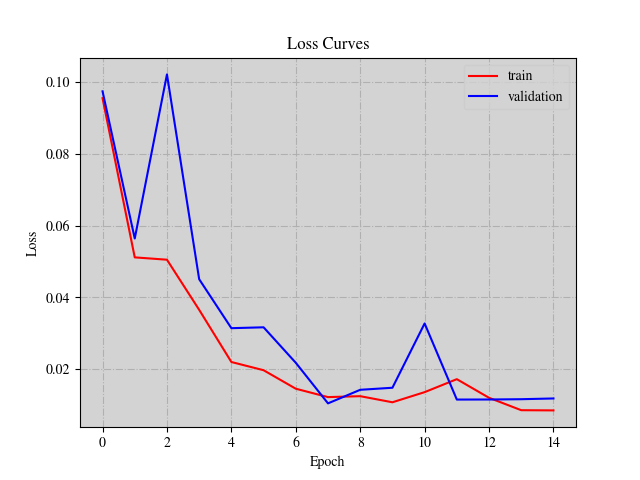

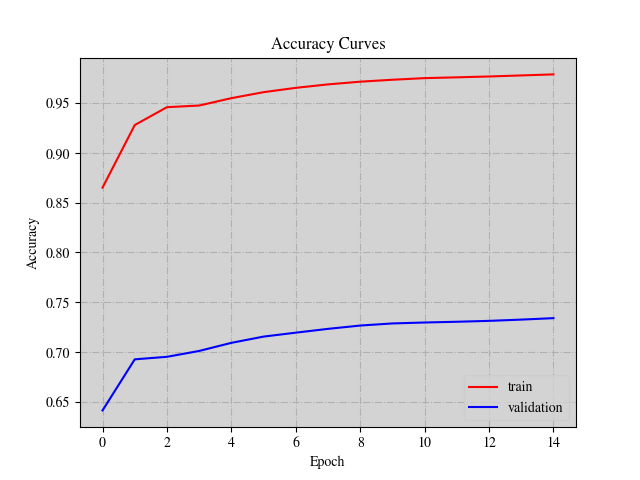

<Figure size 640x480 with 0 Axes>

In [23]:
def _train_loop():
    seed_everything(SEED, workers=True)

    model = MODEL()

    checkpoint = ModelCheckpoint(
        monitor='val_acc',
        mode='max',
        dirpath=EXPERIMENT_DIR,
        filename=f"{MODEL_NAME}_best",
    )
    print(MODEL_NAME)
    early_stopping = EarlyStopping(
        monitor="val_acc",
        min_delta=0.00,
        patience=int(math.ceil(EARLY_STOPPING_PATIENCE * EPOCH)),
        verbose=False,
        mode="max",
    )

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=EPOCH,
        logger=False,
        callbacks=[checkpoint, early_stopping],
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()

## **Testing**

In [24]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = MODEL()
    trainer.test(model=model, ckpt_path=BEST_MODEL_PATH)

_test_loop()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at experiment/SiameseNetwork_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at experiment/SiameseNetwork_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at experiment/SiameseNetwork_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9857942461967468     │
│         test_loss         │   0.011751720681786537    │
└───────────────────────────┴───────────────────────────┘

## **Inference**

### **Store Embeddings**

In [25]:
connection = None
cursor = None

try:
    connection = psycopg2.connect(
        host="localhost",
        port=5432,
        database="medicaldb",
        user="postgres",
        password="postgres"
    )
    cursor = connection.cursor()
    print("Connection established successfully!")
except Exception as e:
    if cursor:
        cursor.close()
    if connection:
        connection.close()
    print("Connection closed successfully!")
    raise SystemError(f"Error connecting to the database: {e}")

Connection established successfully!


In [27]:
model = MODEL.load_from_checkpoint(BEST_MODEL_PATH)
model.eval()

store_embedding_dataset = BiomedicalDataset("store_embedding")
dataloader = data.DataLoader(
    dataset=store_embedding_dataset,
    batch_size=1,
    shuffle=False,
)

for idx, batch in enumerate(dataloader):
    x = batch.to("cpu" if not torch.cuda.is_available() else "cuda")
    embedding = model(x).cpu().data.numpy().reshape(-1).tolist()
    embedding_str = "{"
    for el, element in enumerate(embedding):
        embedding_str += str(element)
        if el != (len(embedding) - 1):
            embedding_str += ", "
    embedding_str +="}"
    try:
        cursor.execute(
            f"INSERT INTO embeddings_table (embedding) VALUES ('{embedding_str}');"
        )
    except Exception as e:
        cursor.close()
        connection.close()
        print("Connection closed successfully!")
        raise SystemError(f"Error connecting to the database: {e}")

connection.commit()

In [28]:
if store_embedding_dataset:
    del store_embedding_dataset
if dataloader:
    del dataloader

In [29]:
if cursor:
    cursor.close()
if connection:
    connection.close()
print("Connection closed successfully!")

Connection closed successfully!


### **Search Similar Images**

#### **Initialization**

In [30]:
connection = None
cursor = None
store_embedding_dataset = None
embeddings = list()
quantizer = faiss.IndexFlatL2(EMBEDDING_DIM)
index = faiss.IndexIVFPQ(quantizer, EMBEDDING_DIM, NLIST, TOPK, BITS)
INDEX_TO_DELETE = list()

try:
    store_embedding_dataset = copy.deepcopy(BiomedicalDataset("store_embedding"))

    print("Num. of Images:", len(store_embedding_dataset.images))

    connection = psycopg2.connect(
        host="localhost",
        port=5432,
        database="medicaldb",
        user="postgres",
        password="postgres"
    )
    cursor = connection.cursor()
    print("Connection established successfully!")

    cursor.execute("SELECT embedding FROM embeddings_table;")
    query_result = cursor.fetchall()

    for idx, element in enumerate(query_result):
        embeddings.append(element[0])
    embeddings = np.array(embeddings)

    print("Embedding shape:", embeddings.shape)

    index.train(embeddings)
    index.add(embeddings)
    index.nprobe = NPROBE

except Exception as e:
    if store_embedding_dataset:
       del store_embedding_dataset
    if cursor:
        cursor.close()
    if connection:
        connection.close()
    print("Connection closed successfully!")
    raise SystemError(f"Error connecting to the database: {e}")

Num. of Images: 15066
Connection established successfully!
Embedding shape: (15066, 16)


#### **Searching for Images**

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

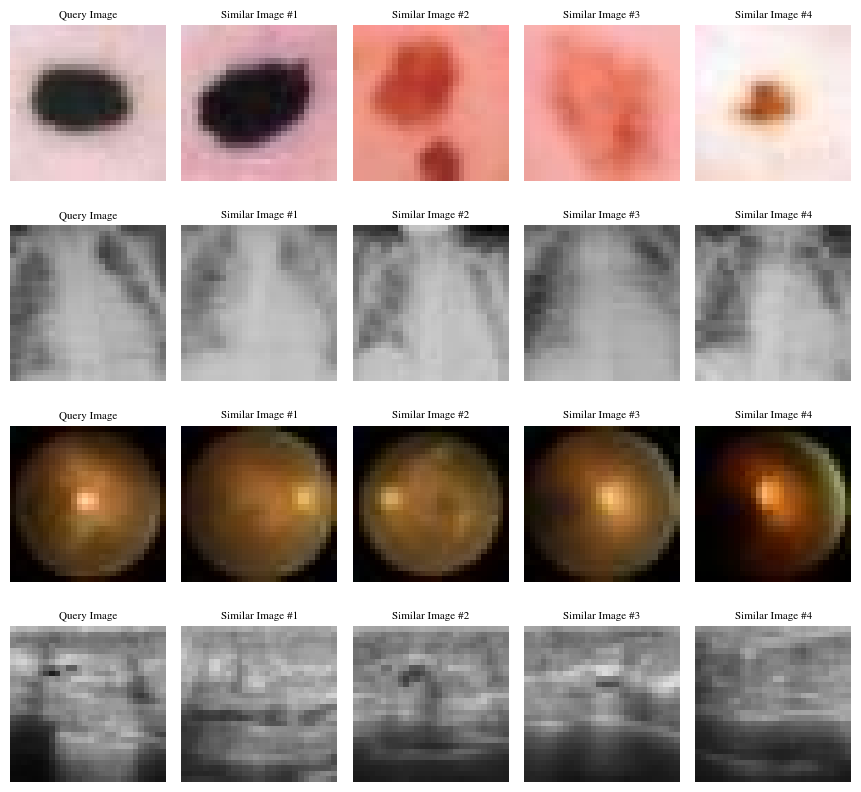

In [31]:
model = MODEL.load_from_checkpoint(BEST_MODEL_PATH)

plt.clf()
fig = plt.figure()
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=math.sqrt(2),
    top=math.sqrt(3),
    wspace=0.1,
    hspace=0.1,
)

TITLE = [
    "Query Image",
    "Similar Image #1",
    "Similar Image #2",
    "Similar Image #3",
    "Similar Image #4",
]

random.seed(SEED)

class_bin = list()

TestDataset = copy.deepcopy(BiomedicalDataset("test"))

for data_index in range(len(DATASET)):

    while True:
        sample_idx = random.randint(0, len(TestDataset) - 1)
        InferenceDataset = copy.deepcopy(BiomedicalDataset("inference", sample_idx))
        inference_label = InferenceDataset.inference_label

        if not inference_label in class_bin:
            class_bin.append(inference_label)
            break

    IMAGES = list()
    IMAGES.append(InferenceDataset.inference_image.copy())

    trainer = Trainer()
    embedding = trainer.predict(
        model=model,
        dataloaders=data.DataLoader(
            dataset=InferenceDataset,
            batch_size=1,
            shuffle=False,
        ),
    )[0].data.cpu().numpy()

    _, INDEX = index.search(embedding, TOPK)

    for idx in INDEX[0].tolist():
        IMAGES.append(store_embedding_dataset.images[idx])

    for idx, image in enumerate(IMAGES):
        image = np.array(image)
        title = f"{TITLE[idx]}"
        ax = fig.add_subplot(
            len(DATASET),
            TOPK + 1,
            (TOPK + 1) * data_index + idx + 1,
        )
        ax.imshow(image.astype(np.uint8))
        ax.set_title(title, fontsize=8)
        ax.set_axis_off()

    del InferenceDataset

plt.show()

#### **Conclude All Experiments**

In [32]:
if store_embedding_dataset:
    del store_embedding_dataset
if cursor:
    cursor.close()
if connection:
    connection.close()
print("Connection closed successfully!")

Connection closed successfully!
